# Hazard Extraction
There are multiple levels of clustering:
1. hazard present vs. hazard not present
2. within hazards, there are general systems in which these occur
3. within each system, there are specific hazards that occur

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import tomotopy as tp

In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

In [3]:
from module.topic_model_plus_class import Topic_Model_plus

### Known Hazards:


In [4]:
subsystems = ["Avionics", "Aircraft Type", "Performance Standards", "Contracting", "Fuel",
             "Mission", "Airspace", "Communication"]
total_hazards = {
    "Avionics": ["avionics failure", "avionics package insufficient for mission complexity", "contract pilot unfamiliar with avionics"],
    "Aircraft Type":["reduced field of view for the flight crew"], 
    "Performance Standards": ["poor engine performance"], 
    "Contracting":["contract pilot skill/fire experience leading to substandard performance"], 
    "Fuel":["capacity, prodcedure, groundfueling errors"],
    "Mission":["restricted visibility", "wake turbulence", "weather", "poor fuel management", "controlled flight into terrain due to low-level ops",
              "collision potential / close proximity to other aircraft", "overly reliant on technology", "aircraft emergency",
              "exceeded span of control", "unclear objectives/tasks", "ATGS performance results in hazardous operations",
              "unnecessary exposure due to inefficient operational use of tactical aircraft", "aircraft operating without aerial supervison",], 
    "Airspace":["Aircraft not complying with FTA procedures", "multiple IA incidents in same area cause confusion",
               "special use airspace, aircraft not coordinating with controlling agency", "non-incident aircraft intrusion in TFR",
               "fires in proximity of airport/strip, potential for MAC"], 
    "Communication":["radio frequency congestion", "resources on different bandwidth", "hazardous air operations due to inaccurate information in dispatch system"]
}

general_systems = len(subsystems)
per_subsystem = [len(total_hazards[subsystem]) for subsystem in total_hazards]
total_specific = sum(per_subsystem)
print(general_systems, total_specific)
print(per_subsystem)


8 28
[3, 1, 1, 1, 1, 13, 5, 3]


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Prepare Data

In [11]:
#data_file = r"C:\Users\srandrad\smart_nlp\input data\ICS_filtered_preprocessed_combined.csv"
#list_of_attributes = ["Combined Text"]
list_of_attributes = ["REMARKS", "SIGNIF_EVENTS_SUMMARY", "MAJOR_PROBLEMS"]
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
name = smart_nlp_path+r"\input data\ICS_clustering_tests"
file_name = smart_nlp_path+r"\input data\209-PLUS\ics209-plus-wildfire\ics209-plus-wildfire\ics209-plus-wf_sitreps_1999to2014.csv"
data_ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, csv_file=file_name, list_of_attributes=list_of_attributes, name=name, combine_cols=True)
data_ICS.prepare_data(dtype=str)
#data_ICS.ngrams = "custom"
#data_ICS.extract_preprocessed_data(data_file)
data = data_ICS.data_df


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Combining Columns…: 100%|████████████████████████████████████████████████████| 120804/120804 [01:37<00:00, 1240.40it/s]


data preparation:  1.683281421661377 minutes 



In [59]:
file = smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined.csv"
filtered_df = pd.read_csv(file)
filtered_ids = filtered_df['INCIDENT_ID'].unique()
data_ICS.data_df = data_ICS.data_df.loc[data_ICS.data_df["INCIDENT_ID"].isin(filtered_ids)].reset_index(drop=True) 
data = data_ICS.data_df
data_ids = data["INCIDENT_ID"].unique()
print(len(filtered_ids), len(data_ids))
data 


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9872 9872


,Unnamed: 0,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"[resource, cactus, share]"
1,1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"[resource, lightning strike, predict, cactus, ..."
2,2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"[resource, lightning strike, predict, cactus, ..."
3,3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333,192.333333,197,196,"[valley, resource, lightning strike, become, c..."
4,4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"[valley, resource, become, cactus, make, compl..."
...,...,...,...,...,...,...,...,...,...,...,...
53249,53249,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,[fuel]
53250,53250,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,[fuel]
53251,53251,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"[edge, lack, disc, heavy, come, agriculture, v..."
53252,53252,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"[perimeter, create, swing, accord, standard, d..."


In [8]:
print(type(data.iloc[0]["Combined Text"]))

<class 'list'>


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english', min_df=5)
X = vectorizer.fit_transform(data["Combined Text"])

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Level 1 Clustering

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


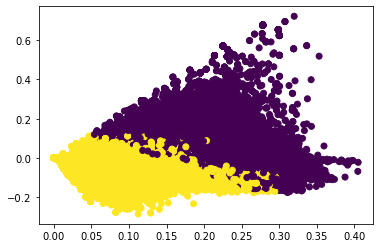

In [14]:
kmeans = KMeans(n_clusters=2, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show()        

## Level 2 Clustering

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


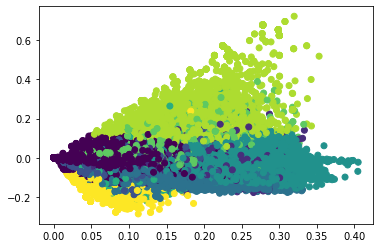

In [15]:
kmeans = KMeans(n_clusters=9, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

## Level 3 Clustering

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


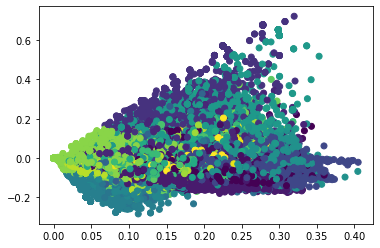

In [16]:
kmeans = KMeans(n_clusters=29, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

## Experimental

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


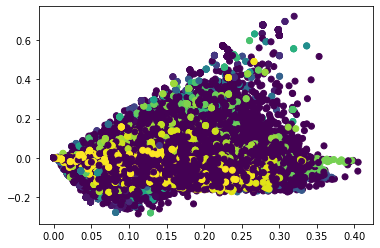

Estimated number of clusters: 279
Estimated number of noise points: 54298
Silhouette Coefficient: -0.205


In [63]:
db = DBSCAN(eps=0.600, min_samples=10, p=np.shape(X)[1], metric = 'l2').fit(X)
labels = db.labels_
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

In [24]:
np.shape(X)[1]

5319

Estimated number of clusters: 309
Estimated number of noise points: 46894
Silhouette Coefficient: -0.185

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
 


ValueError: setting an array element with a sequence.

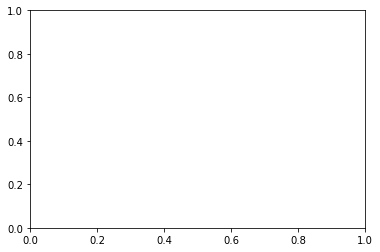

In [26]:
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    print(xy)
    print(type(xy), type(xy[:,0]), type(xy[:,1]))
    print(type(xy), type(list(xy[:,0])[0]), type(list(xy[:,1])[0]))
    print(xy[:,0], xy[:,1])
    plt.plot(list(xy[:, 0]), list(xy[:, 1]), 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(list(xy[:, 0]), list(xy[:, 1]), 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

#### HDP

In [58]:
data_file = r"C:\Users\srandrad\smart_nlp\input data\ICS_filtered_preprocessed_combined.csv"
list_of_attributes = ["Combined Text"]
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
name = smart_nlp_path+r"\input data\HDP_tests"
data_ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, name=name, combine_cols=True)
data_ICS.ngrams = "custom"
data_ICS.extract_preprocessed_data(data_file)
data = data_ICS.data_df
data

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Preprocessed data extracted from:  C:\Users\srandrad\smart_nlp\input data\ICS_filtered_preprocessed_combined.csv


,Unnamed: 0,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"[resource, cactus, share]"
1,1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"[resource, lightning strike, predict, cactus, ..."
2,2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"[resource, lightning strike, predict, cactus, ..."
3,3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333,192.333333,197,196,"[valley, resource, lightning strike, become, c..."
4,4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"[valley, resource, become, cactus, make, compl..."
...,...,...,...,...,...,...,...,...,...,...,...
53249,53249,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,[fuel]
53250,53250,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,[fuel]
53251,53251,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"[edge, lack, disc, heavy, come, agriculture, v..."
53252,53252,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"[perimeter, create, swing, accord, standard, d..."


In [30]:
mdl = tp.HDPModel(tw = tp.TermWeight.IDF)
texts = data["Combined Text"].tolist()
for text in texts:
    mdl.add_doc(text)
for i in range(0, 1000, 10):
    mdl.train(10)
results = {}
results["topic number"]=[]
results["number of words"]=[]
results["topic words"]=[]
#coh = tp.coherence.Coherence(mdl, coherence= "c_v")
#results["coherence per topic"] = [coh.get_score(topic_id=k) for k in range(mdl.k) if (mdl.is_live_topic(k))]
for k in range(mdl.k):
    if not mdl.is_live_topic(k):
        continue
    #results["number of documents in topic"].append(mdl.num_docs_of_topic(k))
    results["topic number"].append(k)
    results["number of words"].append(mdl.get_count_by_topics()[k])
    results["topic words"].append(", ".join([word[0] for word in mdl.get_topic_words(k, top_n=mdl.get_count_by_topics()[k])]))

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
results_df = pd.DataFrame(results)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
print(mdl.k)

48


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
new_lda_model, new_topic_id = mdl.convert_to_lda(topic_threshold=0.05)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
new_lda_model.save("HDP_to_LDA.bin")

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
results_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic number,number of words,topic words
0,0,215481,"concern, continue, impact, closure, forest, in..."
1,1,246131,"continue, threaten, creek, resource, community..."
2,2,2420,"violation, possible violation, value possible ..."
3,3,31301,"unexploded, ordinance, unexploded ordinance, e..."
4,4,102760,"structure, closure, public, evacuation, privat..."
5,5,20145,"smokejumper, crew, secure, demote, continued, ..."
6,6,109,"riparian, core, methodius, lanx, eared, nail, ..."
7,7,203,"april, fill, acre, lark, complex, sister, roan..."
8,8,112,"final submit, submit, habitate, final, call, d..."
9,9,126,"grazing permit, loss forage, grazing, forage, ..."
